<a href="https://colab.research.google.com/github/prakaa/NEMOSIS/blob/master/nem_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 Tutorial: Economic Dispatch

A quick go at translating the old spreadsheet into an interactive notebook


## CoLab Overview

### Why Notebooks?

This is a CoLab notebook that allows you to write text and code within one document, and run it all in your browser. If designed correctly, students need note write much code but can still interact with the notebook and explore 'what-ifs'.

The main benefit of notebooks are:
*   Interactive
*   Analysis in a logical order (vs. Excel)
*   Commentary interspersed
*   CoLab is an easy way for a student to jump straight into writing code, but could also be set up so that students don't need to code




### Writing Python and Text in CoLab
#### Python
 CoLab gives you hints when writing code (autocompletion), and if you hover over a function or variable (in blue), CoLab gives you access to the documentation.

To run the code, you need to run cells. You can either do this using your mouse, or use `Ctrl+Enter` to run a cell or `Shift+Enter` to run a cell and move to the next cell.

#### Text
Simply hover between cells to add a Text cell. The top of the Text cell will have options for writing text in [Markdown](https://guides.github.com/features/mastering-markdown/).



# Simulating Economic Dispatch

In this notebook, we will simulate the economic dispatch in one region of the NEM. The example below from AEMO demonstrates how the 'bid-stack' in the NEM is determined in each five minute interval.

We will simplify the dispatch process by executing economic dispatch for each half hour interval in 2017 for four generators:

1.   PV
2.   Wind
3.   Coal
4.   Gas

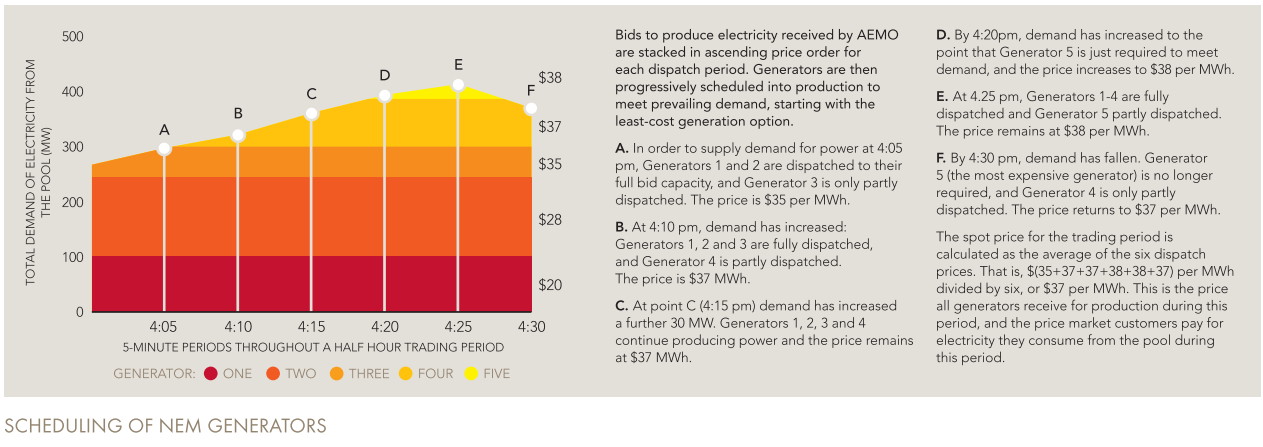

In [ ]:
import pandas as pd

!pip install nempy
from nempy import markets

import ipywidgets as widgets

from functools import partial
from multiprocessing import pool

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from google.colab import files

## Loading and Preparing Data

The cell below pulls data from a csv in my Google Drive. The data is the same data from Luke's old spreadsheet, but has been converted into capacity availability (i.e. % of capacity available to generate).

### Load availability and demand data

The file `available_capacity.csv` contains demand and capacity availability data for each 30 minute interval 

In [ ]:
%load_ext google.colab.data_table
available_capacity = pd.read_csv('/content/drive/MyDrive/Tutoring/SOLA5050/notebooks/available_capacity.csv',
                                 dtype={'Coal': 'Float64', 'Gas': 'Float64',
                                        'Wind': 'Float64', 'PV': 'Float64',
                                        'Demand': 'Float64'},
                                 parse_dates=['TimeEnd'])

Data can be displayed interactively - students can look at and filter raw data.

To make it faster to run `nempy`, I've just truncated the data to one week

In [ ]:
available_capacity = available_capacity.query('TimeEnd <= "2017-01-08 00:30:00"')
available_capacity

,TimeEnd,PV,Wind,Coal,Gas,Demand
0,2017-01-01 00:30:00,0.0,0.010692,0.323377,0.5,660.0
1,2017-01-01 01:00:00,0.0,0.010000,0.419123,0.5,641.0
2,2017-01-01 01:30:00,0.0,0.008192,0.494250,0.5,622.0
3,2017-01-01 02:00:00,0.0,0.003608,0.488250,0.5,603.0
4,2017-01-01 02:30:00,0.0,0.003750,0.487252,0.5,588.0
...,...,...,...,...,...,...
8732,2017-01-07 22:30:00,0.0,0.015008,0.365753,0.5,871.0
8733,2017-01-07 23:00:00,0.0,0.015275,0.461377,0.5,845.0
8734,2017-01-07 23:30:00,0.0,0.011950,0.465127,0.5,832.0
10175,2017-01-08 00:00:00,0.0,0.068742,0.457627,0.5,775.0


### Functions for executing dispatch

Code blocks can be hidden to make it easier for a student to use the notebook

In [ ]:
def execute_dispatch(volume, demand, price, info):
  '''
  Takes unit volume and price data, demand data and unit info
  and executes dispatch in a single-region market
  '''
  # create a SpotMarket object for NSW, with units as described in info
  market = markets.SpotMarket(unit_info=info, market_regions=['NSW'])

  # assign volume to the SpotMarket object
  market.set_unit_volume_bids(volume)

  # assign demand to the SpotMarket object
  market.set_demand_constraints(demand)
  # supply can be less demand, but at a shortfall cost of $15,000
  market.make_constraints_elastic('demand', violation_cost=15000.0)

  # assign price bids to the SpotMarket object
  market.set_unit_price_bids(price)

  # execute dispatch
  market.dispatch()
  return market


def set_up_economic_dispatch(pv_cap, wind_cap, gas_cap, coal_cap, price_bids,
                             row):
  row_data = row[1]
  # prepare unit info data for units in the NSW region
  unit_info = pd.DataFrame({
    'unit': ['PV', 'Wind', 'Gas', 'Coal'],
    'region': ['NSW', 'NSW', 'NSW', 'NSW']
  })

  # prepare demand input data
  demand = pd.DataFrame({
    'region': ['NSW'],
    'demand': [row_data['Demand']]
  })
  # prepare volume input data based on availability and total capacity
  volume_bids = pd.DataFrame({
      'unit': ['PV', 'Wind', 'Coal', 'Gas'],
      '1': [row_data['PV'] * pv_cap, row_data['Wind'] * wind_cap, 
            row_data['Coal'] * coal_cap, row_data['Gas'] * gas_cap]
  })

  market = execute_dispatch(volume_bids, demand, price_bids, unit_info)
  result = {row_data['TimeEnd']: market}
  return result

def economic_dispatch_by_interval(pv_bid, wind_bid, gas_bid, coal_bid,
                                  pv_cap, wind_cap, gas_cap, coal_cap,
                                  available_capacity):
  '''
  Takes input from availability data and widgets
  '''
  # prepare price bid data
  price_bids = pd.DataFrame({
    'unit': ['PV', 'Wind', 'Gas', 'Coal'],
    '1': [pv_bid, wind_bid, gas_bid, coal_bid]
  })
  
  # prepare to iterate through rows of availability and demand data
  # then spawn multiple processes to speed up execution of economic dispatch
  gen = available_capacity.iterrows()
  # we build a partial function as only one function argument can be passed
  # across processes
  partial_func = partial(set_up_economic_dispatch, 
                         pv_cap, wind_cap,
                         gas_cap, coal_cap,
                         price_bids)
  outputs = {}
  with pool.Pool() as parallel_pool:
    for result in parallel_pool.imap(partial_func, gen,
                                     chunksize=30):
      outputs.update(result)
  
  return outputs

### Enter units bids

This is a simple version, I can make this so all sliders/boxes automatically trigger dispatch calc and plotting


#### Marginal cost data

The table below contains SRMC and LRMC data for each of the 4 generators in $/MWh

In [ ]:
marginal_costs = pd.DataFrame([[3, 100], [12, 89], [20, 35], [100, 150]],
                              index=['PV', 'Wind', 'Coal', 'Gas'],
                              columns=['SRMC', 'LRMC'])
marginal_costs

,SRMC,LRMC
PV,3,100
Wind,12,89
Coal,20,35
Gas,100,150


In [ ]:
pv_bid = widgets.BoundedFloatText(marginal_costs.loc['PV', 'SRMC'],
                                  min=-1000, 
                                  max=14500, 
                                  description='PV Bid')
wind_bid = widgets.BoundedFloatText(marginal_costs.loc['Wind', 'SRMC'],
                                    min=-1000, 
                                    max=14500, 
                                    description='Wind Bid')
gas_bid = widgets.BoundedFloatText(marginal_costs.loc['Gas', 'SRMC'],
                                   min=-1000, 
                                   max=14500, 
                                   description='Gas Bid')
coal_bid = widgets.BoundedFloatText(marginal_costs.loc['Coal', 'SRMC'],
                                    min=-1000, 
                                    max=14500, 
                                    description='Coal Bid')
display(pv_bid, wind_bid, gas_bid, coal_bid)

BoundedFloatText(value=3.0, description='PV Bid', max=14500.0, min=-1000.0)

BoundedFloatText(value=12.0, description='Wind Bid', max=14500.0, min=-1000.0)

BoundedFloatText(value=100.0, description='Gas Bid', max=14500.0, min=-1000.0)

BoundedFloatText(value=20.0, description='Coal Bid', max=14500.0, min=-1000.0)

### Enter units capacities

This is a simple version, I can make this so all sliders/boxes automatically trigger dispatch calc and plotting

In [ ]:
pv_cap = widgets.BoundedFloatText(150,
                                  min=0, 
                                  max=1000, 
                                  description='PV Cap')
wind_cap = widgets.BoundedFloatText(1200,
                                    min=0, 
                                    max=3000, 
                                    description='Wind Cap')
gas_cap = widgets.BoundedFloatText(1000,
                                   min=0, 
                                   max=2000, 
                                   description='Gas Cap')
coal_cap = widgets.BoundedFloatText(1500,
                                    min=0, 
                                    max=3000, 
                                    description='Coal Cap')
display(pv_cap, wind_cap, gas_cap, coal_cap)

BoundedFloatText(value=150.0, description='PV Cap', max=1000.0)

BoundedFloatText(value=1200.0, description='Wind Cap', max=3000.0)

BoundedFloatText(value=1000.0, description='Gas Cap', max=2000.0)

BoundedFloatText(value=1500.0, description='Coal Cap', max=3000.0)

### Run dispatch

In [ ]:
results = economic_dispatch_by_interval(pv_bid=pv_bid.value, 
                                        wind_bid=wind_bid.value,
                                        gas_bid=gas_bid.value, 
                                        coal_bid=coal_bid.value,
                                        pv_cap=pv_cap.value,
                                        wind_cap=wind_cap.value,
                                        gas_cap=gas_cap.value,
                                        coal_cap=coal_cap.value, 
                                        available_capacity=available_capacity)

In [ ]:
demand = available_capacity.set_index('TimeEnd')['Demand']
price = pd.Series({time: results[time].get_energy_prices().loc[0, 'price'] 
                   for time in available_capacity['TimeEnd']},
                   name='price')

raw_dispatch = {time: results[time].get_unit_dispatch()
                for time in available_capacity['TimeEnd']}
for time in raw_dispatch.keys():
  raw_dispatch[time]['TimeEnd'] = time
dispatch = pd.concat(raw_dispatch.values())

### Plot and display results

In [ ]:
fig = px.area(dispatch, x="TimeEnd", y="dispatch", color="unit",
              labels=dict(dispatch="Dispatched Quantity (MW)",
                          TimeEnd="Date and Time"),
              color_discrete_map={"Coal": "dimgrey", "Gas": "red",
                                  "Wind": "lightgreen", "PV": "gold"},
              title='Dispatch Result for NSW Region (One Week)')
demand_line = go.Scatter(x=demand.index, y=demand, name='Demand',
                         line={'dash': '2px', 'color': 'black'})
fig.add_trace(demand_line)
fig.show()

In [ ]:
fig = go.Figure()
price_line = go.Scatter(x=price.index, y=price, name='Price')
fig.add_trace(price_line)
fig.update_layout(
    title="NSW Region Price (One Week)",
    xaxis_title="Date and Time",
    yaxis_title="$/MWh"
    )

### Download data

In [ ]:
data = pd.concat([dispatch.set_index('TimeEnd'), price, demand], axis=1)
data.to_csv('dispatch_data.csv')
files.download('dispatch_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>